# Cross-validation and polynomial regression

## Polynomial regression

Polynomial regression consists of fitting some data $(x, y)$ to a $n$-order polynomial of the form:

$$
 y = f(x) = b + w_1 \cdot x + w_2 \cdot x^2 + ... + w_n \cdot x^n
$$

By rewriting the unidimensional input $x$ into the following vector:

$$
 \mathbf{x} = \begin{bmatrix} x & x^2 & ... & x^n \end{bmatrix}^T
$$

and the weight vector as:

$$
 \mathbf{w} = \begin{bmatrix} w_1 & w_2 & ... & w_n \end{bmatrix}^T
$$

the problem can be reduced to linear regression:

$$
 y = \langle \mathbf{w}, \mathbf{x} \rangle + b
$$

 and we can apply the delta learning rule to find $\mathbf{w}$ and $b$:

$$
 \Delta \mathbf{w} =  \eta \, (t_i - y_i ) \, \mathbf{x_i}
$$
$$
 \Delta b =  \eta (t_i - y_i )
$$

A first method to perform polynomial regression would be to adapt the code you wrote in the last exercise session for linear regression. However, you saw that properly setting the correct learning rate can be quite tricky.

The solution retained for this exercise is to use the built-in functions of Numpy which can already perform polynomial regression in an optimized and proved-sure manner (Note: NumPy does not use gradient descent, but rather directly minimizes the error-function by inversing the Gram matrix).

```python
w = np.polyfit(X, t, deg)
```

This function takes the inputs $X$, the desired outputs $t$ and the desired degree of the polynomial `deg`, performs the polynomial regression and returns the adequate set of weights (beware: the higher-order coefficient comes first, the bias is last).

Once the weights are obtained, one can use them to predict the value of an example with the function:

```python
y = np.polyval(w, X)
```

*Note:* if you prefer to use scikit-learn, check <https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html> but see <https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2> for why it may be a bad idea.

Let's start by importing the usual stuff and create a dataset of 16 samples generated using the function $x \, \sin x$ plus some noise:

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Just to avoid the annoying warnings, please ignore
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def create_dataset(N, noise):
    "Creates a dataset of N points generated from x*sin(x) plus some noise."

    x = np.linspace(0, 10, 300)
    rng = np.random.default_rng()
    rng.shuffle(x)
    x = np.sort(x[:N])
    t = x * np.sin(x) + noise*rng.uniform(-1.0, 1.0, N)

    return x, t

N = 16
X, t = create_dataset(N, noise=0.2)

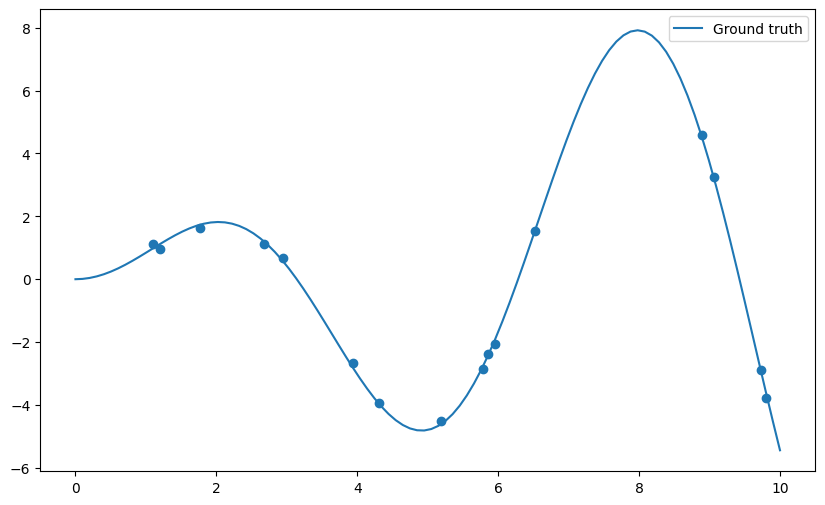

In [2]:
x = np.linspace(0, 10, 100)

plt.figure(figsize=(10, 6))
plt.plot(x, x*np.sin(x), label="Ground truth")
plt.scatter(X, t)
plt.legend()
plt.show()

**Q:** Apply the `np.polyfit()` function on the data and visualize the result for different degrees of the polynomial (from 1 to 20 or even more). What do you observe? Find a polynomial degree which clearly overfits.

In [13]:
#Code to ensure that random data generated is the same accross runs

"""
def create_dataset(N, noise, seed=42):
    "Creates a dataset of N points generated from x*sin(x) plus some noise."

    x = np.linspace(0, 10, 300)
    rng = np.random.default_rng(seed)  # Set random seed for reproducibility
    rng.shuffle(x)
    x = np.sort(x[:N])
    t = x * np.sin(x) + noise * rng.uniform(-1.0, 1.0, N)

    return x, t

# Use the fixed seed
N = 16
X, t = create_dataset(N, noise=0.2, seed=42)
"""


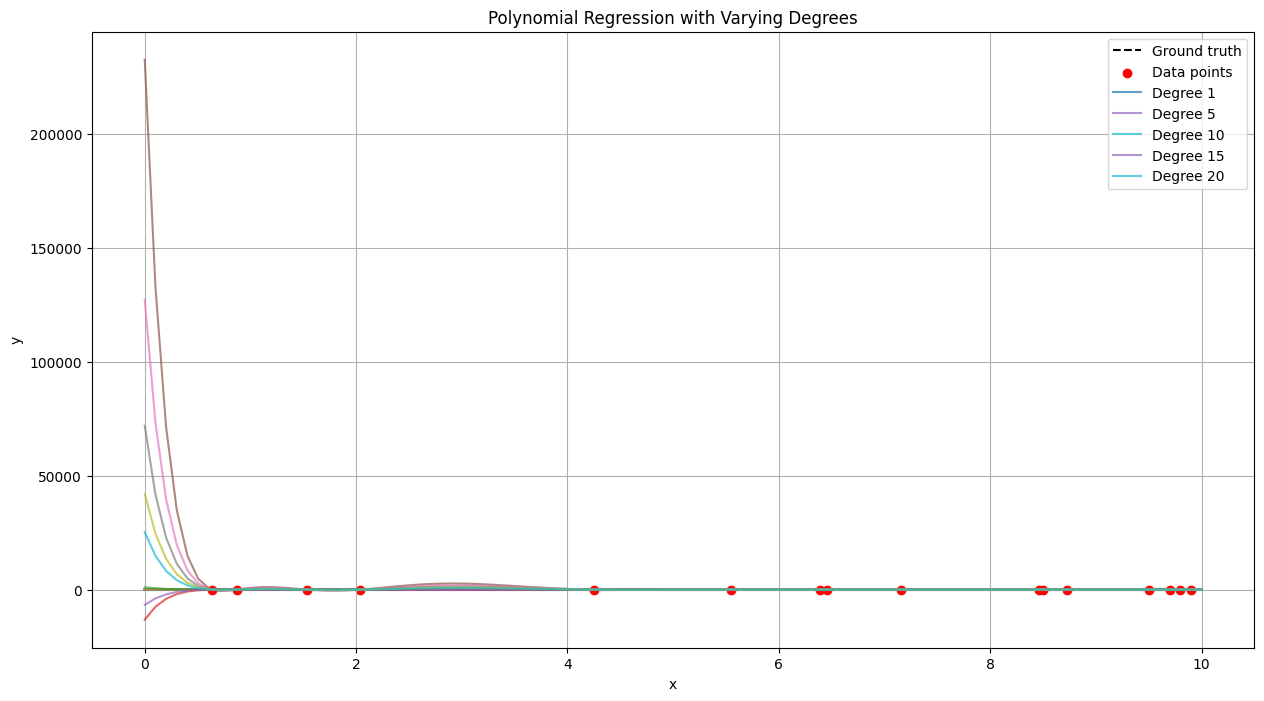

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create dataset
N = 16
X, t = create_dataset(N, noise=0.2)
x = np.linspace(0, 10, 100)  # Fine grid for visualization

# Plot ground truth and data points
plt.figure(figsize=(15, 8))
plt.plot(x, x * np.sin(x), label="Ground truth", color="black", linestyle="--")
plt.scatter(X, t, label="Data points", color="red")

# Fit and visualize polynomials of varying degrees Polynomial degrees from 1 to 20
degrees = range(1, 21)
 # Perform polynomial regression
for deg in degrees:
    w = np.polyfit(X, t, deg)
    y = np.polyval(w, x)

    # Plot polynomial

    plt.plot(x, y, label=f"Degree {deg}" if deg in {1, 5, 10, 15, 20} else None, alpha=0.7)

plt.legend()
plt.title("Polynomial Regression with Varying Degrees")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()


**Q:** Plot the mean square error on the training set for all polynomial regressions from 1 to 20. How does the training error evolve when the degree of the polynomial is increased? What is the risk by taking the hypothesis with the smallest training error?

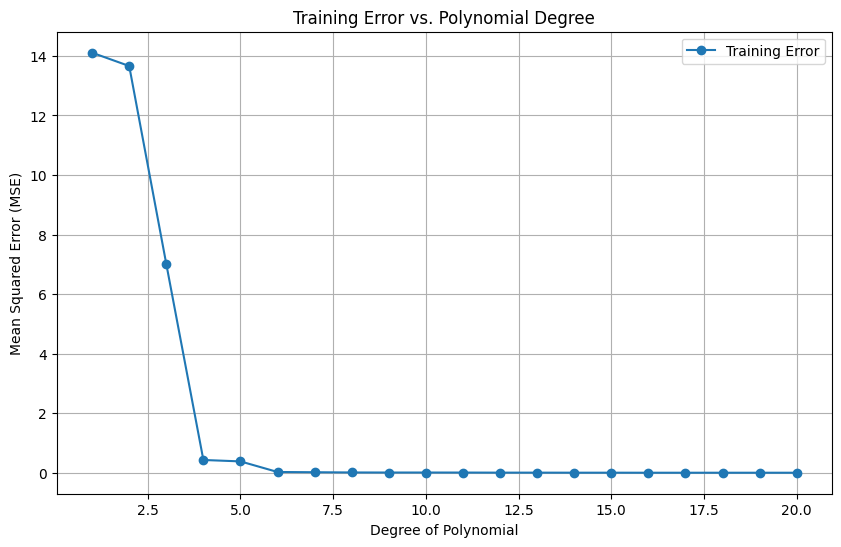

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse the fixed dataset
#N = 16
#X, t = create_dataset(N, noise=0.2, seed=42)

# Compute training error for degrees 1 to 20
degrees = range(1, 21)
training_errors = []

for deg in degrees:
    # Fit the polynomial
    w = np.polyfit(X, t, deg)
    # Predict on the training data
    y_train_pred = np.polyval(w, X)
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((t - y_train_pred) ** 2)
    training_errors.append(mse)

# Plot the training error vs degree
plt.figure(figsize=(10, 6))
plt.plot(degrees, training_errors, marker='o', label="Training Error")
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training Error vs. Polynomial Degree")
plt.grid()
plt.legend()
plt.show()


## Simple hold-out cross-validation

You will now apply **simple hold-out cross-validation** to find the optimal degree for the polynomial regression. You will need to separate the data set into a training set $S_{\text{train}}$ (70% of the data) and a test set $S_{\text{test}}$ (the remaining 30%).

The data (X, t) could be easily split into two sets of arrays using slices of indices, as the data is already randomized:

```python
N_train = int(0.7*N)
X_train, t_train = X[:N_train], t[:N_train]
X_test, t_test = X[N_train:], t[N_train:]
```

A much more generic approach is to use the library `scikit-learn` (<https://www.scikit-learn.org>), which provides a method able to split any dataset randomly.

You can import the method `train_test_split()` from its module:

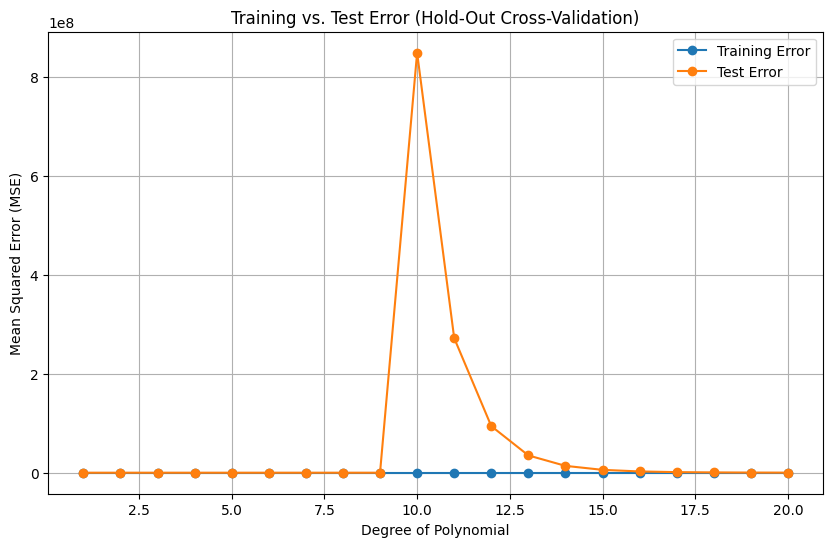

In [20]:
from sklearn.model_selection import train_test_split
# Split dataset into training and testing
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=42)

# Evaluate polynomial regression for degrees 1 to 20
train_errors = []
test_errors = []

for deg in degrees:
    # Fit the polynomial on the training set
    w = np.polyfit(X_train, t_train, deg)

    # Predictions on training and testing sets
    y_train_pred = np.polyval(w, X_train)
    y_test_pred = np.polyval(w, X_test)

    # Calculate MSE for training and testing sets
    train_mse = np.mean((t_train - y_train_pred) ** 2)
    test_mse = np.mean((t_test - y_test_pred) ** 2)

    train_errors.append(train_mse)
    test_errors.append(test_mse)

# Plot training and test errors
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label="Training Error", marker='o')
plt.plot(degrees, test_errors, label="Test Error", marker='o')
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training vs. Test Error (Hold-Out Cross-Validation)")
plt.legend()
plt.grid()
plt.show()



The doc of the function is available at: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>.

**Q:** Use scikit-learn to split the data into the corresponding training and test sets. Train each polynomial from degree 1 to 20 on $S_{\text{train}}$ and plot the generalization error on $S_{\text{test}}$. Which degree of the polynomial gives the minimal empirical error? Why? Run the cross-validation split multiple times. Do you always obtain the same optimal degree?

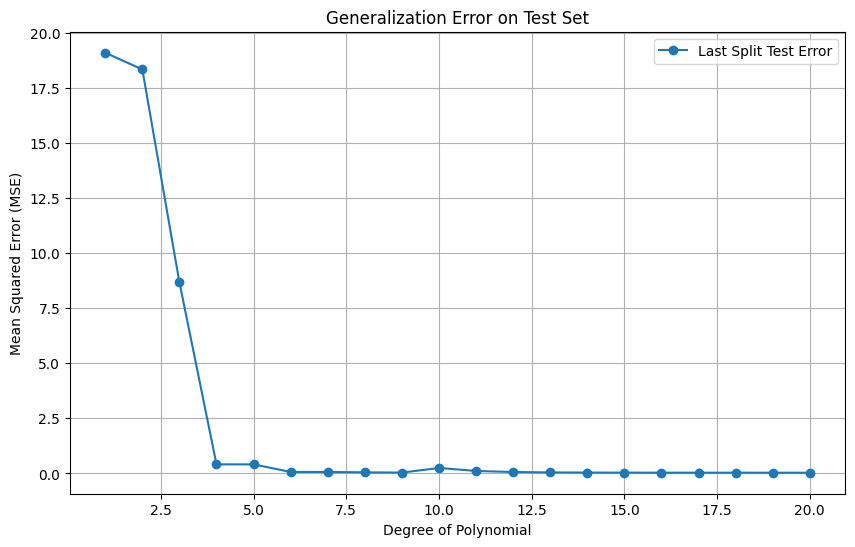

Optimal degree for each split: [ 8  5  7  4  6  6  8  7  6 20]
Most common optimal degree: 6


In [21]:
from sklearn.model_selection import train_test_split
"""
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 16
num_splits = 10  # Number of random splits
degrees = range(1, 21)  # Polynomial degrees to evaluate
"""

num_splits = 10  # Number of random splits
generalization_errors = []  # To store errors for each split

# Function to compute test error for each split
for split in range(num_splits):
    # Split the data into training and test sets
    X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=split)
    test_errors = []

    for deg in degrees:
        # Fit polynomial on the training set
        w = np.polyfit(X_train, t_train, deg)
        # Predict on the test set
        y_test_pred = np.polyval(w, X_test)
        # Compute the Mean Squared Error (MSE) on the test set
        test_mse = np.mean((t_test - y_test_pred) ** 2)
        test_errors.append(test_mse)

    generalization_errors.append(test_errors)

# Convert to a NumPy array for easier analysis
generalization_errors = np.array(generalization_errors)

# Plot the generalization error for the last split
plt.figure(figsize=(10, 6))
plt.plot(degrees, generalization_errors[-1], label="Last Split Test Error", marker="o")
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Generalization Error on Test Set")
plt.legend()
plt.grid()
plt.show()

# Find and print the optimal degree for each split
optimal_degrees = np.argmin(generalization_errors, axis=1) + 1  # Add 1 because indices start at 0
print("Optimal degree for each split:", optimal_degrees)

# Check the variability of optimal degrees
print("Most common optimal degree:", np.bincount(optimal_degrees).argmax())


## k-fold cross-validation

As we only have 16 samples to learn from, it is quite annoying to "lose" 5 of them for the test set. Here we can afford to use **k-fold cross-validation**, where the cross-validation split is performed $k$ times:

* The dataset is split into $k$ subsets of equal size (if possible).
* Each subset is iteratively used as the test set, while the $k-1$ other ones are used as a training set.
* The final empirical error is the average of the mse on all subsets.

It would be possible to make the splits using indices too, but it is much easier to use `scikit-learn` once again. You can import the `KFold` class like this:

In [ ]:
from sklearn.model_selection import KFold

k = 4
kf = KFold(n_splits=k, shuffle=True)

`n_splits` corresponds to $k$: how many times the dataset is split. We can take $k=4$ for example (4 subsets of 4 samples).

**Q:** Check the doc of `KFold` (<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html>). Print the indices of the examples of the training and test sets for each iteration of the algorithm. Change the value of $k$ to understand how it works.

**Q:** Apply k-fold cross-validation on the polynomial regression problem. Which polynomial degree is the best? Run the split multiple times: does the best polynomial degree change?

**Q:** Change $k$ to $N$. How stable are the results between two runs?

**Q:** Regenerate the data with a noise equal to 0.0 and re-run all experiments. What does it change?